In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yaml
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from algorithms import get_model
from utils.data import * # process_data

In [3]:
CONFIG_PATH = "./experiments/lightgbm0.yaml"
with open(CONFIG_PATH, 'r') as f:
    config = yaml.load(f, Loader=yaml.Loader)
config

{'name': 'lightgbm0',
 'algo': 'lightgbm',
 'weights_path': './weights/lightgbm0.pkl',
 'model_params': {'boosting_type': 'gbdt',
  'num_leaves': 50,
  'max_depth': -1,
  'learning_rate': 0.2,
  'n_estimators': 200,
  'objective': 'MAE'},
 'hyper_search': {'num_leaves': ['int', 2, 31],
  'n_estimators': ['int', 50, 300],
  'max_depth': ['int', 3, 8],
  'min_child_samples': ['float', 100, 1200],
  'learning_rate': ['float', 0.0001, 0.99],
  'min_data_in_leaf': ['int', 5, 90],
  'bagging_fraction': ['float', 0.0001, 1.0],
  'feature_fraction': ['float', 0.0001, 1.0]},
 'data': {'ips_file': './data/OxCGRT_latest.csv',
  'nb_lookback_days': 1,
  'y': 'NewCasesRM'}}

In [4]:
def mae(pred, true):
    return np.mean(np.abs(pred - true))

In [5]:
IPS_PATH = './data/OxCGRT_latest.csv'
df = pd.read_csv(IPS_PATH,
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str},
                 error_bad_lines=True)
df = process_df(df)
df = df.set_index('Date')
gdf = df[df.GeoID == 'Italy__nan']

/home/schapke/miniconda2/envs/xprize/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Warning! Interpolating missing ConfirmedCases statistics. (This will affect the ground truth labels NewCases).


(<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>)

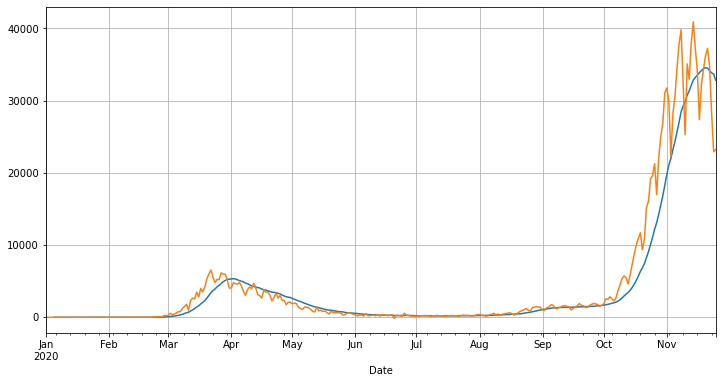

In [6]:
gdf.NewCasesRM.plot(figsize=(12, 6)), gdf.NewCases.plot(figsize=(12, 6), grid=True)

<AxesSubplot:xlabel='Date'>

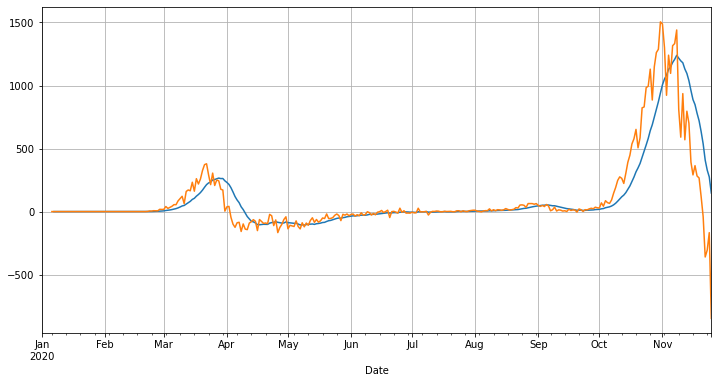

In [7]:
#gdf.AccCases.rolling(7, center=True, min_periods=3).mean().plot(figsize=(12, 6), grid=True)
gdf.AccCasesRM.plot(figsize=(12, 6), grid=True)
gdf.AccCases.plot(figsize=(12, 6), grid=True)

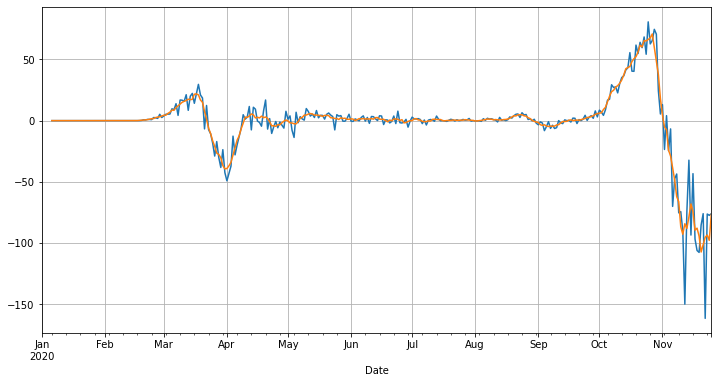

In [8]:
acc = gdf.AccCases.rolling(7, center=True, min_periods=3).mean()
ax = acc.diff(1).plot(figsize=(12,6), grid=True)
ax = acc.diff(1).rolling(5, center=True, min_periods=3).mean().plot(ax=ax, grid=True)

<AxesSubplot:xlabel='Date'>

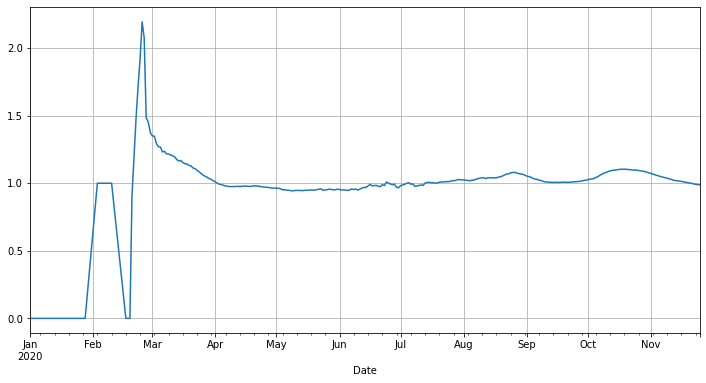

In [9]:
gdf.NewCasesRMGrowth.rolling(7, center=True, min_periods=3).mean().plot(figsize=(12, 6), grid=True)

<AxesSubplot:xlabel='Date'>

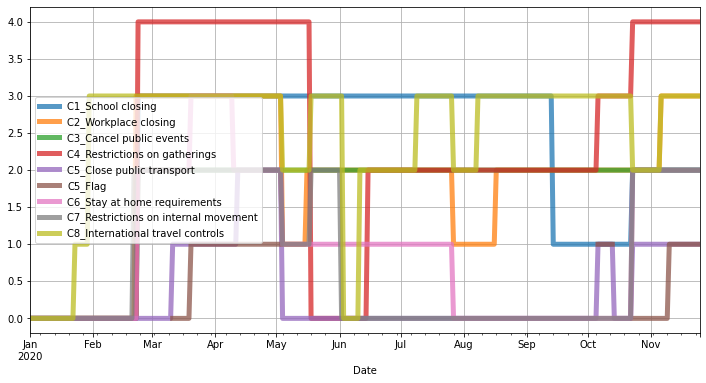

In [10]:
gdf[['C1_School closing',
       'C2_Workplace closing','C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements',
       'C7_Restrictions on internal movement',
       'C8_International travel controls']].plot(figsize=(12,6), linewidth=5, alpha=0.75, grid=True)

# TRAINING

In [11]:
## Load historical intervention plans, since inception
X, y, info = get_data(config)

# For testing, restrict training data to that before a hypothetical predictor submission date
#h_date = HYPOTHETICAL_SUBMISSION_DATE = pd.to_datetime("2020-09-01")
#train_X = X.loc[:HYPOTHETICAL_SUBMISSION_DATE]
#train_y = y.loc[:HYPOTHETICAL_SUBMISSION_DATE]
#test_X = X.loc[HYPOTHETICAL_SUBMISSION_DAjTE:]
#test_y = y.loc[HYPOTHETICAL_SUBMISSION_DATE:]

/home/schapke/miniconda2/envs/xprize/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Warning! Interpolating missing ConfirmedCases statistics. (This will affect the ground truth labels NewCases).


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, 
                                                    test_size=0.2, 
                                                    random_state=298)

In [13]:
model = get_model(config)

{'linear': <class 'algorithms.linear.Linear'>, 'catboost': <class 'algorithms.catboost.CatBoost'>, 'lightgbm': <class 'algorithms.lightgbm.LightGBM'>, 'ensemble': <class 'algorithms.ensemble.Ensemble'>}
lightgbm


In [14]:
model.train(X_train, y_train, X_test, y_test, info)
# Save the model
# model.save(config["weights_path"])

/home/schapke/miniconda2/envs/xprize/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/schapke/miniconda2/envs/xprize/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events', 'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C8_International travel controls', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/schapke/miniconda2/envs/xprize/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Referen

[1]	valid_0's l1: 873.763
[2]	valid_0's l1: 832.833
[3]	valid_0's l1: 792.64
[4]	valid_0's l1: 756.803
[5]	valid_0's l1: 723.183
[6]	valid_0's l1: 691.903
[7]	valid_0's l1: 661.516
[8]	valid_0's l1: 630.721
[9]	valid_0's l1: 602.331
[10]	valid_0's l1: 572.385
[11]	valid_0's l1: 543.045
[12]	valid_0's l1: 512.616
[13]	valid_0's l1: 484.578
[14]	valid_0's l1: 456.003
[15]	valid_0's l1: 427.895
[16]	valid_0's l1: 400.71
[17]	valid_0's l1: 373.235
[18]	valid_0's l1: 347.962
[19]	valid_0's l1: 321.761
[20]	valid_0's l1: 285.381
[21]	valid_0's l1: 248.502
[22]	valid_0's l1: 222.372
[23]	valid_0's l1: 198.791
[24]	valid_0's l1: 179.653
[25]	valid_0's l1: 167.666
[26]	valid_0's l1: 147.578
[27]	valid_0's l1: 131.484
[28]	valid_0's l1: 119.532
[29]	valid_0's l1: 113.61
[30]	valid_0's l1: 107.794
[31]	valid_0's l1: 106.367
[32]	valid_0's l1: 104.036
[33]	valid_0's l1: 98.3895
[34]	valid_0's l1: 95.3262
[35]	valid_0's l1: 95.3191
[36]	valid_0's l1: 93.3234
[37]	valid_0's l1: 89.071
[38]	valid_0's

In [15]:
test_preds = model.predict(X_test)
print(f"Test MAE: {mae(test_preds, y_test)}")
print(f"Train MAE: {mae(model.predict(X_train), y_train)}")
#print(f"Samples MAE: {mae(model.predict(X_samples), y_samples)}")

Test MAE: 81.3245906160495
Train MAE: 63.7765682257347


# FORECASTS

In [68]:
data = Data(config)

/home/schapke/miniconda2/envs/xprize/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Warning! Interpolating missing ConfirmedCases statistics. (This will affect the ground truth labels NewCases).


In [114]:
fore_date = pd.to_datetime("2020-11-26")
n_fore = 30
iterator = data.build_test_iter(fore_date, n_fore=n_fore)

TypeError: __new__() got an unexpected keyword argument 'days'

In [107]:
X = iterator()

In [122]:
last_date = fore_date - pd.Timedelta(days=1)
data.df.loc[last_date]

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,...,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay,NewCases,NewCasesRM,AccCases,AccCasesRM,NewCasesRMGrowth,NewCasesRMGrowthRM
GeoID,,,,,,,,,,,,,,,,,,,,,
Afghanistan__nan,Afghanistan,AFG,NaN,NaN,NAT_TOTAL,0.0,NaN,0.0,NaN,0.0,...,NaN,20.83,NaN,0.0,185.0,216.750,16.861111,6.583333,1.084352,1.039440
Albania__nan,Albania,ALB,NaN,NaN,NAT_TOTAL,1.0,NaN,2.0,NaN,2.0,...,NaN,71.53,NaN,50.0,744.0,733.500,14.611111,14.227273,1.020325,1.021347
Algeria__nan,Algeria,DZA,NaN,NaN,NAT_TOTAL,2.0,NaN,1.0,NaN,1.0,...,NaN,71.53,NaN,50.0,1133.0,1051.375,15.708333,16.367424,1.015167,1.014897
Andorra__nan,Andorra,AND,NaN,NaN,NAT_TOTAL,1.0,NaN,2.0,NaN,2.0,...,NaN,67.36,NaN,100.0,47.0,54.625,1.402778,-0.761364,1.026357,0.976420
Angola__nan,Angola,AGO,NaN,NaN,NAT_TOTAL,2.0,NaN,2.0,NaN,1.0,...,NaN,60.76,NaN,25.0,141.0,147.875,7.875000,1.503788,1.056250,1.014031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela__nan,Venezuela,VEN,NaN,NaN,NAT_TOTAL,3.0,NaN,2.0,NaN,2.0,...,NaN,79.86,NaN,50.0,355.0,344.875,-4.680556,-17.102273,0.986610,0.990789
Vietnam__nan,Vietnam,VNM,NaN,NaN,NAT_TOTAL,0.0,NaN,2.0,NaN,0.0,...,NaN,44.79,NaN,50.0,4.0,4.125,0.236111,-0.443182,1.060714,0.949301
Yemen__nan,Yemen,YEM,NaN,NaN,NAT_TOTAL,2.0,NaN,0.0,NaN,0.0,...,NaN,22.92,NaN,0.0,7.0,5.250,0.583333,0.477273,1.125000,1.094358


In [103]:
fore = 30
date = fore_date
sdf= data.df.loc[date-pd.Timedelta(days=14):date]
sdf

CountryName CountryCode RegionName RegionCode  \
Date       GeoID                                                             
2020-11-12 Afghanistan__nan  Afghanistan         AFG        NaN        NaN   
           Albania__nan          Albania         ALB        NaN        NaN   
           Algeria__nan          Algeria         DZA        NaN        NaN   
           Andorra__nan          Andorra         AND        NaN        NaN   
           Angola__nan            Angola         AGO        NaN        NaN   
...                                  ...         ...        ...        ...   
2020-11-25 Venezuela__nan      Venezuela         VEN        NaN        NaN   
           Vietnam__nan          Vietnam         VNM        NaN        NaN   
           Yemen__nan              Yemen         YEM        NaN        NaN   
           Zambia__nan            Zambia         ZMB        NaN        NaN   
           Zimbabwe__nan        Zimbabwe         ZWE        NaN        NaN   

                            Jurisdiction  C1_School closing  C1_Flag  \
Date       GeoID                                                       
2020-11-12 Afghanistan__nan    NAT_TOTAL                0.0      NaN   
           Albania__nan        NAT_TOTAL                1.0      1.0   
           Algeria__nan        NAT_TOTAL                2.0      1.0   
           Andorra__nan        NAT_TOTAL                1.0      1.0   
           Angola__nan         NAT_TOTAL                2.0      1.0   
...                                  ...                ...      ...   
2020-11-25 Venezuela__nan      NAT_TOTAL                3.0      NaN   
           Vietnam__nan        NAT_TOTAL                0.0      NaN   
           Yemen__nan          NAT_TOTAL                2.0      NaN   
           Zambia__nan         NAT_TOTAL                1.0      NaN   
           Zimbabwe__nan       NAT_TOTAL                1.0      NaN   

                             C2_Workplace closing  C2_Flag  \
Date       GeoID                                             
2020-11-12 Afghanistan__nan                   0.0      NaN   
           Albania__nan                       2.0      1.0   
           Algeria__nan                       1.0      1.0   
           Andorra__nan                       2.0      1.0   
           Angola__nan                        2.0      1.0   
...                                           ...      ...   
2020-11-25 Venezuela__nan                     2.0      NaN   
           Vietnam__nan                       2.0      NaN   
           Yemen__nan                         0.0      NaN   
           Zambia__nan                        2.0      NaN   
           Zimbabwe__nan                      1.0      NaN   

                             C3_Cancel public events  ...  \
Date       GeoID                                      ...   
2020-11-12 Afghanistan__nan                      0.0  ...   
           Albania__nan                          2.0  ...   
           Algeria__nan                          1.0  ...   
           Andorra__nan                          2.0  ...   
           Angola__nan                           1.0  ...   
...                                              ...  ...   
2020-11-25 Venezuela__nan                        2.0  ...   
           Vietnam__nan                          0.0  ...   
           Yemen__nan                            0.0  ...   
           Zambia__nan                           1.0  ...   
           Zimbabwe__nan                         2.0  ...   

                             ContainmentHealthIndex  \
Date       GeoID                                      
2020-11-12 Afghanistan__nan                   20.83   
           Albania__nan                       71.53   
           Algeria__nan                       71.53   
           Andorra__nan                       64.58   
           Angola__nan                          NaN   
...                                             ...   
2020-11-25 Venezuela__nan           

In [46]:
fore_array, fore_df = make_forecasts(fore_X, model)
rfore_df = rfore_df.rename(columns={"Forecast": "NewCasesRMGrowthRM"})
rfore_y = pd.concat(fore_y).to_frame('NewCasesRMGrowthRM')

ValueError: Input data must be 2 dimensional and non empty.

In [475]:
pfore_df = process_forecasts(df, fore_df, config)
pfore_y = df.NewCasesRM.loc[pfore_df.index]
pfore_y = pfore_y.to_frame('NewCasesRM')

In [476]:
print("Groud-truth:")
pfore_y.head()

Groud-truth:


,,NewCasesRM
GeoID,Date,
Aruba__nan,2020-08-31,63.857143
Afghanistan__nan,2020-08-31,23.214286
Angola__nan,2020-08-31,57.714286
Albania__nan,2020-08-31,130.500000
Andorra__nan,2020-08-31,12.142857


In [477]:
print("Forecasts:")
pfore_df.head()

Forecasts:


,,NewCasesRM
GeoID,Date,
Aruba__nan,2020-08-31,69.000000
Afghanistan__nan,2020-08-31,3.000000
Angola__nan,2020-08-31,80.287879
Albania__nan,2020-08-31,84.000000
Andorra__nan,2020-08-31,0.000000


In [478]:
print("Diff:")
(pfore_df - pfore_y).head()

Diff:


,,NewCasesRM
GeoID,Date,
Aruba__nan,2020-08-31,5.142857
Afghanistan__nan,2020-08-31,-20.214286
Angola__nan,2020-08-31,22.573593
Albania__nan,2020-08-31,-46.500000
Andorra__nan,2020-08-31,-12.142857


Text(0.5, 1.0, 'Forecasts (NewCasesRMGrowthRM) for : Brazil__Rio Grande do Sul')

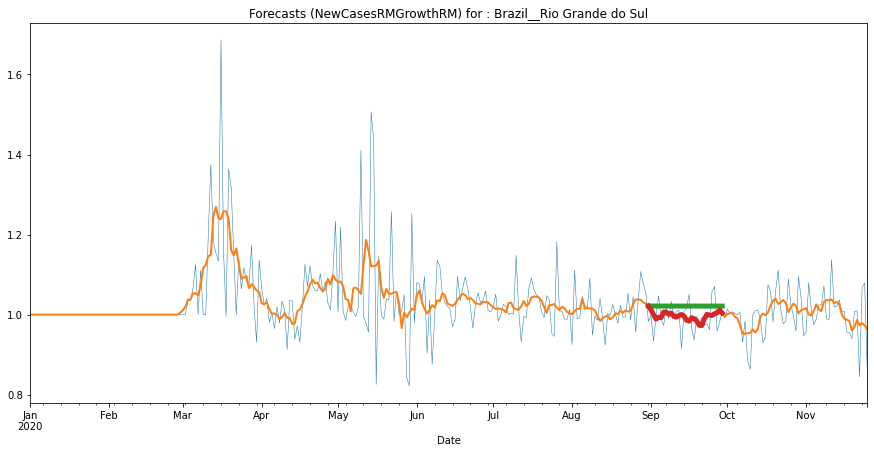

In [483]:
geo_id = 'Brazil__Rio Grande do Sul'
key = "NewCasesRMGrowthRM"

df.loc[geo_id][key[:-2]].plot(figsize=(15, 7), linewidth=0.5)
df.loc[geo_id][key].plot(linewidth=2)
rfore_df.loc[geo_id][key].plot(linewidth=5)
axes = rfore_y.loc[geo_id][key].plot(linewidth=5)
axes.set_title(f'Forecasts ({key}) for : {geo_id}')

Text(0.5, 1.0, 'Forecasts (NewCases) for : Brazil__Rio Grande do Sul')

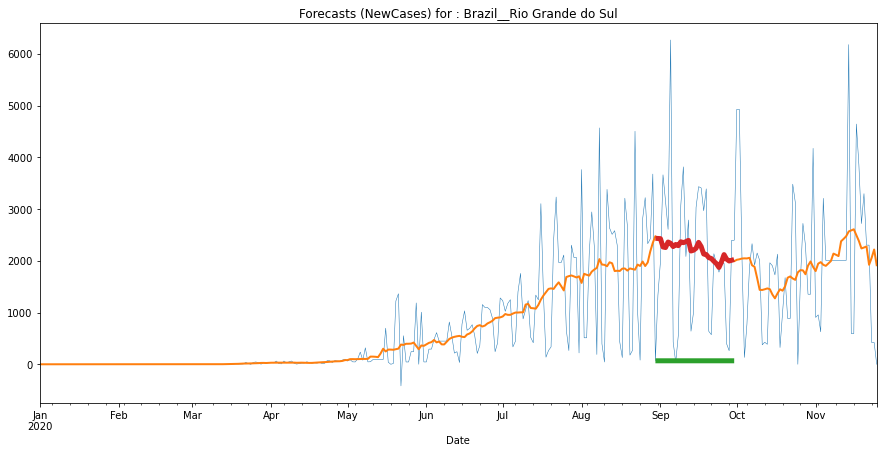

In [456]:
geo_id = 'Brazil__Rio Grande do Sul'
df.loc[geo_id].NewCases.plot(figsize=(15, 7), linewidth=0.5)
df.loc[geo_id].NewCasesRM.plot(linewidth=2)
pfore_df.loc[geo_id].NewCasesRM.plot(linewidth=5)
axes = pfore_y.loc[geo_id].NewCasesRM.plot(linewidth=5)
axes.set_title(f'Forecasts (NewCases) for : {geo_id}')

# EVALUATION

In [430]:
#print(f'Raw Forecast MAE error (date: {fore_date}, n_forecasts: {n_fore}):', 
#      mae(pfore_y, pfore_df))
print(f'Processed Forecast MAE error (fore_date: {fore_date}, n_fore: {n_fore}):', 
      mae(pfore_y, pfore_df).values[0])

Processed Forecast MAE error (fore_date: 2020-08-31, n_fore: 30): 377.82256131830997


# ANALYSIS

In [478]:
import matplotlib.gridspec as mgrid
import shap
shap.initjs()

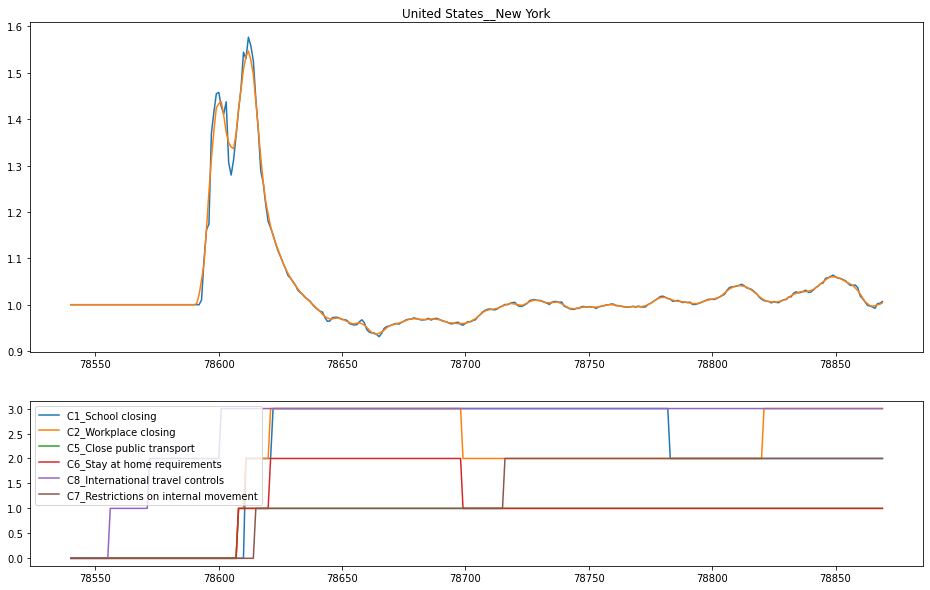

In [502]:
def plot_country(geo_id):
    fig = plt.figure(figsize=(16,10))
    grid = mgrid.GridSpec(nrows=2, ncols=1, height_ratios=[2, 1])
    ax1 = fig.add_subplot(grid[0])
    ax2 = fig.add_subplot(grid[1])
    
    gdf = df[df.GeoID == geo_id]
    gdf.NewCasesRMGrowthRM.plot(ax=ax1, title=geo_id)
    gdf.NewCasesRMGrowthRM.rolling(window=5, center=True, min_periods=2).mean().plot(ax=ax1)
    
    #gdf.GovernmentResponseIndex.plot(ax=ax2)
    gdf[["C1_School closing", "C2_Workplace closing", 
         "C5_Close public transport", "C6_Stay at home requirements",
        "C8_International travel controls", "C7_Restrictions on internal movement"]].plot(ax=ax2, kind='line')
plot_country("United States__New York")


In [480]:
booster = model.model._Booster
booster

In [481]:
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test)

In [492]:
X_test

,,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,...,C8_International travel controls_Diff4,H1_Public information campaigns_Diff4,H2_Testing policy_Diff4,H3_Contact tracing_Diff4,H6_Facial Coverings_Diff4,NewCasesRMGrowthRM-Diff1,NewCasesRMGrowthRM-Diff7,NPISum-Diff2,NPISum-Diff4,NPISum-Diff8
GeoID,Date,,,,,,,,,,,,,,,,,,,,,
Uganda__nan,2020-05-19,3.0,2.0,2.0,4.0,2.0,1.0,2.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.108542,0.091913,-1.0,-1.0,-1.0
Honduras__nan,2020-01-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
Costa Rica__nan,2020-03-20,3.0,2.0,2.0,0.0,0.0,0.0,2.0,4.0,2.0,1.0,...,4.0,0.0,0.0,0.0,0.0,0.015376,-0.060087,0.0,7.0,7.0
Hong Kong__nan,2020-07-08,2.0,0.0,0.0,3.0,0.0,1.0,0.0,4.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.020036,0.110256,0.0,0.0,0.0
Solomon Islands__nan,2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe__nan,2020-04-11,3.0,3.0,2.0,3.0,1.0,2.0,2.0,4.0,2.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.000000,0.055855,0.0,1.0,1.0
Georgia__nan,2020-03-11,3.0,0.0,2.0,0.0,0.0,1.0,0.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-0.003861,-0.052074,0.0,1.0,1.0
United States__Rhode Island,2020-02-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [497]:
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])

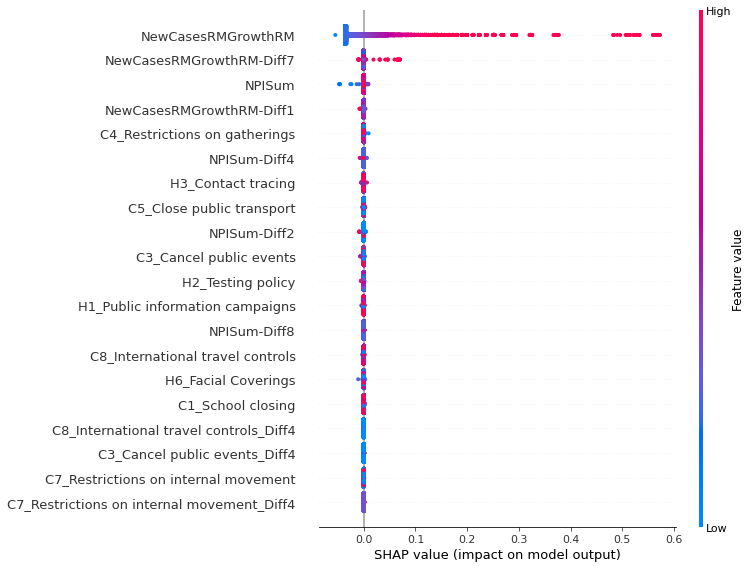

In [498]:
shap.summary_plot(shap_values, X_test)